# Implementação do Algoritmo das Projeções Sucessivas

O algoritmo busca identificar as variáveis mais relevantes para um problema de regressão linear múltipla a partir da eliminação das variáveis com informação redundante.

O critério de eliminação das variáveis é a sua colinearidade em relação a outras variáveis, o que é calculado a partir da projeção da primeira em subespaços osrtogonais às últimas.

Os trabalhos utilizados como base para esta implementação são:

>   _M. C. U. Araújo, T. C. B. Saldanha, R. K. H. Galvão, T. Yoneyama, H. C. Chame and V. Visani, “The Successive     Projections Algorithm for Variable Selection in Spectroscopic Multicomponent”, Chemometrics and Intelligent Laboratory   Systems, Vol. 57, No. 2, p. 65-73, 2001._ 

> GUI do Algoritmo das Projeções Sucessivas, disponível em http://www.ele.ita.br/~kawakami/spa

### Progresso:

<input type="checkbox" checked> Implementar projeções com decomposição QR

<input type="checkbox" checked> Refazer implementação das outras funções baseado nos códigos otimizados

<input type="checkbox" checked> Comparar resultado da minha implementação com a implementação do chinês

<input type="checkbox" checked> Comparar resultado da minha implementação com a implementação original (dados corn.mat)

<input type="checkbox" unchecked> Implementar funções para ELM

<input type="checkbox" unchecked> Colocar os comentários das funções do APS em inglês e esse notebook em inglês

### Notas:

- Projeções com decomposição QR chegaram a ser 260 vezes mais rápidas do que com as rotinas originais (com k0=0 e N=5, rotinas originais levaram 1.3 segundos e QR levou 0.005 segundos). Os resultados foram iguais.

- Por enquanto, não vou implementar a Fase 3 do APS porque ela não segue exatamente a ideia de minimizar a colinearidade, mas sim a de eliminar variáveis com pouco poder preditivo.

- Como a implementação do aBugsLife é uma "tradução" do código original para python, meu código estar funcionando igual ao dele praticamente implica que estará funcionando igual ao original.

---

## Bibliotecas utilizadas

In [1]:
# Versões das bibliotecas usadas estão listadas no arquivo requirements.txt
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import pandas as pd
from scipy.linalg import qr
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.io import loadmat
from sklearn.metrics.pairwise import pairwise_distances
from kennard_stone import train_test_split

# Funções desenvolvidas
from utils.aps_utils import *

In [2]:
# Configuração do estilo do plot
plt.style.use(['grid', 'science', 'notebook'])

---

## Teste com os dados utilizados pelo aBugsLife

Como a minha implementação foi fortemente baseada na implementação do SPA do [aBugsLife](https://gitee.com/aBugsLife/SPA/tree/master) (que, por sua vez, foi fortemente baseada na implementação em Matlab original), vou comparar o comportamento dos nossos códigos quando apresentados a um mesmo conjunto de dados.

Os dados utilizados são referentes à espectroscopia de pêssegos, visando determinar o nível de açúcar (em graus Brix) nos mesmos. Desse modo, cada coluna é referente a um comprimento de onda medido nas análises laboratoriais e cada linha é referente a uma amostra diferente. Assim, cada elemento $(i,j)$ da tabela de dados representa a intensidade de luz que uma amostra $i$ apresenta em um comprimento de onda $j$.

In [3]:
# Ler dados
peach_brix_data = pd.read_csv("./aBugsLife/SPA/data/peach_spectra_brix.csv")
peach_brix_data[:5]

FileNotFoundError: [Errno 2] No such file or directory: './aBugsLife/SPA/data/peach_spectra_brix.csv'

In [4]:
print("Formato dos dados：", peach_brix_data.shape)

# Os dados apresentam 50 amostras e 600 comprimentos de onda medidos.
#
# A primeira coluna dos dados é o teor de açúcar em cada amostra, ou seja, a variável a ser prevista.
x = peach_brix_data.drop(['Brix'], axis=1)
y = peach_brix_data.loc[:,'Brix'].values

Formato dos dados： (50, 601)


In [5]:
# O autor normaliza os dados entre -1 e 1 antes de passá-los pelas funções
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

x_scaled = min_max_scaler.fit_transform(x)

In [6]:
# Divisão dos dados em calibração e validação
from sklearn.model_selection import train_test_split

# O autor testa diferentes configurações de divisão calibração-validação. Nesse caso, 40% dos dados são
# destinados para validação.
xcal, xval, ycal, yval = train_test_split(x_scaled, y, test_size=0.4, random_state=0)

Evaluation of variable subsets: 100%|██████████| 600/600 [00:03<00:00, 181.62it/s]


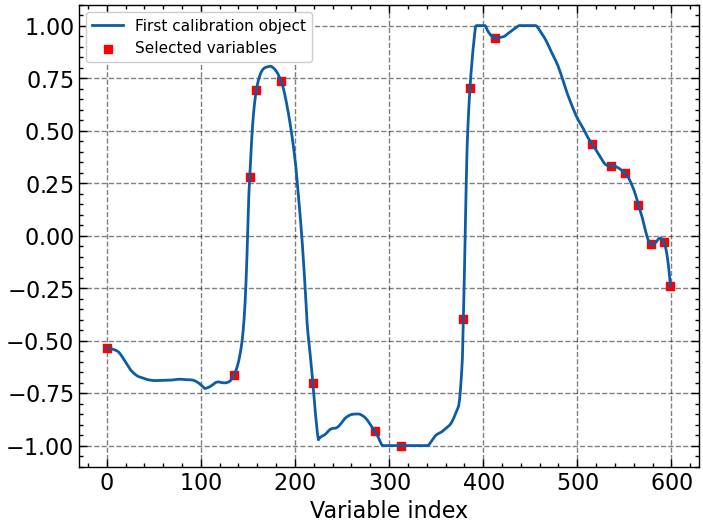

In [7]:
# Execução das duas primeiras fases do SPA
#
# O autor original utiliza a terceira fase também, mas ela não é interessante ainda
# para as aplicações que eu quero dar para o algoritmo
#
# SEL é o conjunto de variáveis selecionadas
SEL = spa(xcal, ycal, 
        M_min=2, M_max=28,
        xval=xval, yval=yval,
        plot=True)

### Variáveis selecionadas pelo código do aBugsLife na fase 2

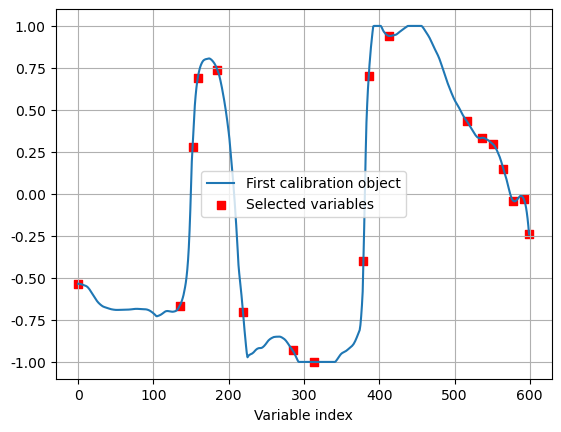

Observa-se que os códigos realizaram a mesma seleção de variáveis na fase 2, validando as minhas mudanças no código do autor.

---

## Teste com dados de quimiometria sugeridos pelos autores do APS

Originalmente, o método foi proposto como uma forma de selecionar **comprimentos de onda relevantes** para análises espectroscópicas. Nesse tipo de análise, mede-se a intensidade de luz refletida por um corpo para cada comprimento de onda da luz, então costuma-se ter **muitos dados**. Nos dados sugeridos pelos autores do APS, cada linha corresponde à intensidade da luz em uma das 80 amostras do corpo e cada coluna representa a intensidade da luz em um dos 700 comprimentos de onda medidos. Assim, se eu plotar um comprimento de onda, vou ter 80 pontos que correspondem a medidas individuais da intensidade de luz nesse comprimento de onda. Por outro lado, se eu plotar uma amostra, vou ter 700 pontos que correspondem à intensidade de luz dessa amostra em cada comprimento de onda.

O intuito final é predizer características da amostra (umidade do milho, quantidade de amido etc.) baseado na sua resposta a diferentes comprimentos de onda, então seleciona-se os **comprimentos de onda** com menor informação redundante sobre as amostras.

In [4]:
# Os dados de entrada, 'data', são a intensidade de luz para cada comprimento de onda
#
# Os dados de saída, 'targets', são algumas propriedades da substância a serem preditas baseado na espectroscopia
# (a saber, umidade, oleosidade, proteína e amido (starch))
corn = loadmat('../arquivos/corn.mat')
data = np.array(corn['m5spec'])
targets = np.array(corn['propvals'])

# Dados numéricos
numericData = data[0][0][7]
wavelengths = data[0][0][9][1][0][0] # Comprimentos de onda
numericTargets = targets[0][0][7]
properties = targets[0][0][8][1][0] # Propriedades a serem previstas

# Conversão para dataframe do pandas com os comprimentos de onda / propriedades sendo as colunas 
dataTable = pd.DataFrame(numericData, columns=wavelengths)
targetsTable = pd.DataFrame(numericTargets, columns=properties)

# No GUI, os autores usam a derivada (derivada de Savitzky-Golay) das linhas da tabela de dados
dataTable = dataTable.diff(axis=1).iloc[:,1:]

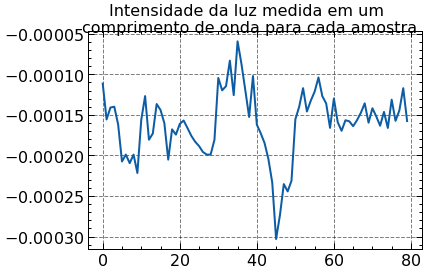

In [5]:
plt.plot(dataTable.iloc[:,0])
plt.suptitle('Intensidade da luz medida em um \ncomprimento de onda para cada amostra', fontsize=16)
plt.show()

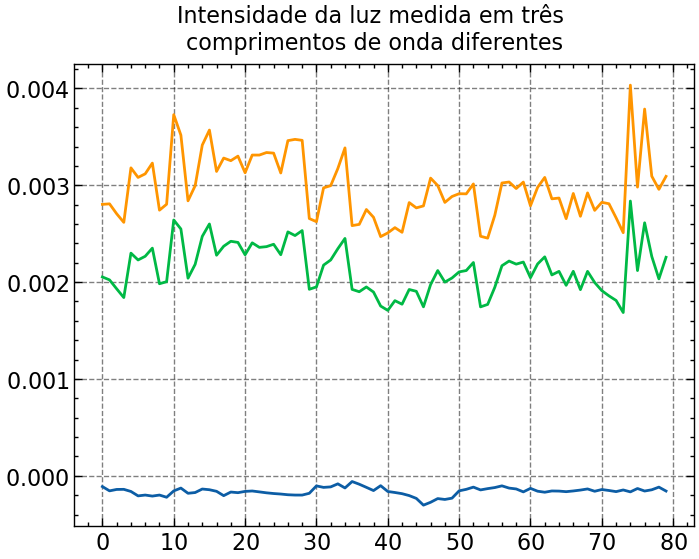

In [128]:
plt.plot(dataTable.iloc[:,[0,15,30]])
plt.suptitle('Intensidade da luz medida em três \ncomprimentos de onda diferentes', fontsize=16)
plt.show()

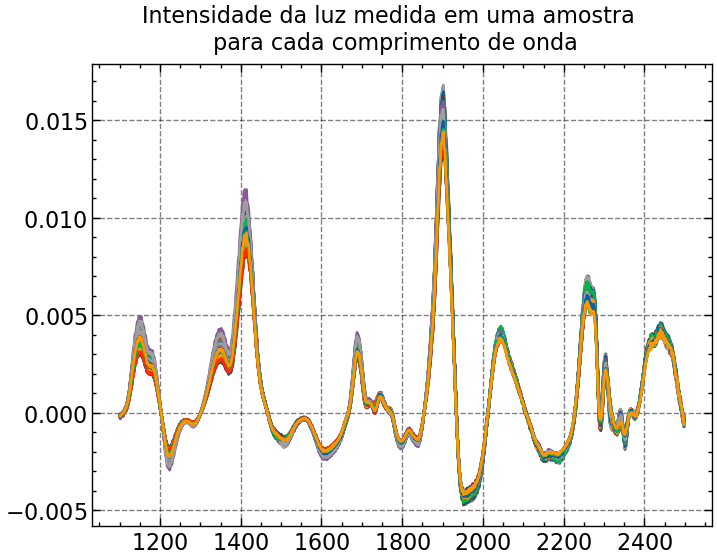

In [129]:
plt.plot(dataTable.transpose().iloc[:,:])
plt.suptitle('Intensidade da luz medida em uma amostra \n para cada comprimento de onda', fontsize=16)
plt.show()

Vou aplicar o APS para a seleção dos comprimentos de onda mais relevantes. Inicialmente, vou dividir os dados em calibração, validação e teste utilizando o método Kennard-Stone (KS), como sugerido no manual da GUI do APS.

In [130]:
# No manual, propõe-se usar 40 amostras pra calibração
testRatio = 0.5

# Vou utilizar implementação do pacote kennard_stone
#
# Inicialmente, vou separar em calibração e teste
xcal, xtest, ycal, ytest = train_test_split(dataTable.values, targetsTable['Moisture'].values, test_size=testRatio)
#
# Em seguida, vou separar os dados de teste em validação e teste
xval, xtest, yval, ytest = train_test_split(xtest, ytest, test_size=testRatio)


Agora, vou testar o algoritmo:

In [42]:
# Aplicação das 2 primeiras fases do APS
M_max = 39
M_min = 1
SEL = spa(xcal, ycal, xval, yval, 1, 30)
print(f'''\nComprimentos de onda selecionados: {SEL}''')

AssertionError: Parâmetro M_max inválido: o número máximo de variáveis selecionadas é N

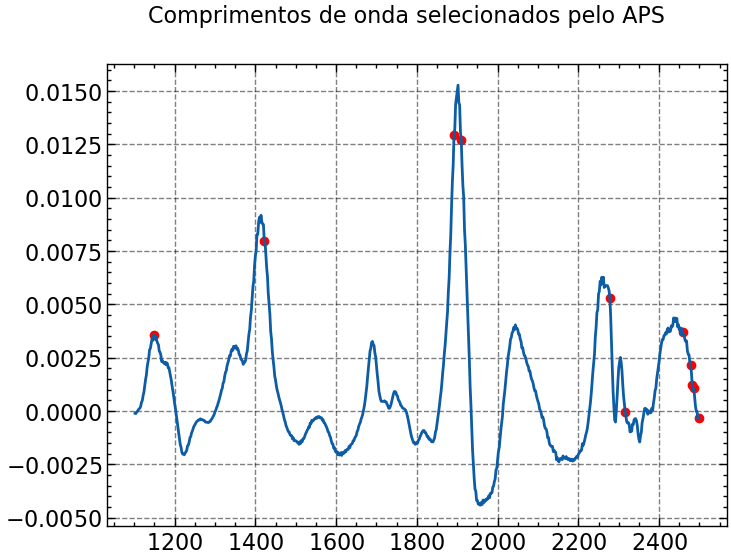

In [143]:
plt.plot(dataTable.transpose().iloc[:,0])
plt.scatter(x=dataTable.transpose().index.values[SEL], 
            y=dataTable.transpose().iloc[:,0].values[SEL],
            marker='o', color='red')
plt.suptitle('Comprimentos de onda selecionados pelo APS', fontsize=16)
plt.show()

Por fim, vou comparar o desempenho do modelo de regressão linear múltipla com e sem o APS:

In [98]:
# Regressão linear múltipla
mlr = linear_model.LinearRegression()
mlrAPS = linear_model.LinearRegression()

In [134]:
# Sem APS

# Obtenção do modelo de MLR
mlr.fit(xcal, ycal)

# Teste do modelo 
yhat = mlr.predict(xtest)
RMSE = np.sqrt(np.mean((ytest-yhat)**2))

print(f'''RMSE sem APS: {round(RMSE, 5)}
Número de comprimentos de onda usados: {xcal.shape[1]}''')

RMSE sem APS: 0.04819
Número de comprimentos de onda usados: 699


In [135]:
# Com APS

# Obtenção do modelo de MLR
mlrAPS.fit(xcal[:,SEL], ycal)

# Teste do modelo 
yhatAPS = mlrAPS.predict(xtest[:,SEL])
apsRMSE = np.sqrt(np.mean((ytest-yhatAPS)**2))

print(f'''RMSE com APS: {round(apsRMSE, 5)}
Número de comprimentos de onda usados: {xcal[:,SEL].shape[1]}''')

RMSE com APS: 0.15083
Número de comprimentos de onda usados: 13


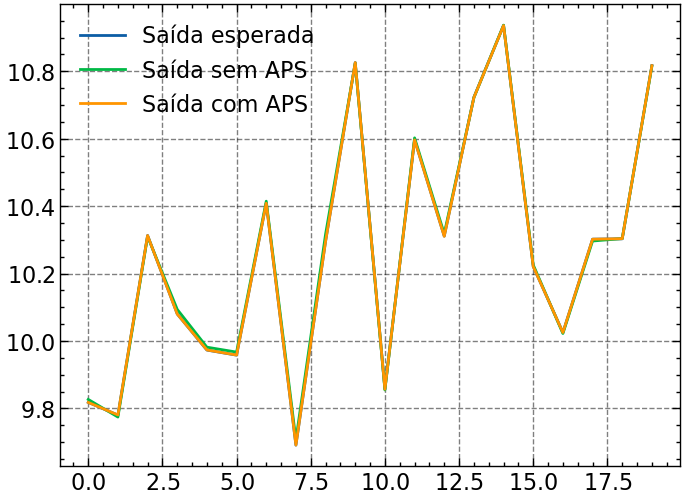

In [102]:
plt.plot(ytest)
plt.plot(yhat)
plt.plot(yhatAPS)
plt.legend(['Saída esperada','Saída sem APS','Saída com APS'])
plt.show()

---